#  Predección de demanda semana de carnes en la tienda 1

El objetivo del problema es predecir la demanda semanal de carnes de la tienda 1 con dos semanas de anticipación. Se asume que las ordenes se realizan los Viernes en horario am, por lo que no se conoce la demanda de ese día. Por ejemplo, si la orden se hizó el 2019-12-13 esta llegará el 2019-12-27, siendo las ventas del 2019-12-12 hacia atras conocidas. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta
from sqlalchemy import create_engine
from tensorflow import keras
from tensorflow.keras import layers

2022-05-17 00:54:28.587896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 00:54:28.587922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Obtener los ventas de la Tienda 1 en la categoría "CARNES"

In [2]:
engine = create_engine("sqlite:///problemas_seleccion.db")
conection = engine.connect()
query = """
    SELECT 
      tv.fecha,
      tv.ventas
    FROM TABLA_VENTAS AS tv
    INNER JOIN TABLA_CATEGORIAS AS tc
    ON tv.tienda = 1
      AND tv.id_categoria = tc.id_categoria
      AND tc.categoria = "CARNES"
    """
df = pd.read_sql(query, engine, parse_dates=["FECHA"])

## 2. Descripción de la base de datos

In [3]:
df.head(), df.tail()

(       FECHA  VENTAS
 0 2017-08-01  1142.0
 1 2017-08-02  1079.0
 2 2017-08-03  1096.0
 3 2017-08-04  2430.0
 4 2017-08-05  4261.0,
          FECHA       VENTAS
 847 2019-12-11  1290.206994
 848 2019-12-12  1387.618000
 849 2019-12-13  2535.910981
 850 2019-12-14  4388.873985
 851 2019-12-15  3643.656030)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   852 non-null    datetime64[ns]
 1   VENTAS  852 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.4 KB


In [5]:
df.describe()

,VENTAS
count,852.000000
mean,2287.154957
std,1605.793504
min,362.000000
25%,1086.000000
50%,1799.688996
75%,3008.363742
max,10878.000000


In [6]:
df.isna().sum()

FECHA     0
VENTAS    0
dtype: int64

In [7]:
df.FECHA.min(), df.FECHA.max()

(Timestamp('2017-08-01 00:00:00'), Timestamp('2019-12-15 00:00:00'))

In [8]:
df.FECHA.max()-df.FECHA.min()

Timedelta('866 days 00:00:00')

## 3. Eleccción de métrica de desempeño y división del conjunto de los datos en train, validation y test.

La métrica que se escoge es el MAE (Mean Absolute Error), la cual corresponde al promedio de los errores absolutos entre las prediciones y el valor real. El MAE penaliza de igual manera la sobreestimación y subestimación de la demanda, por lo que si estos costos no son simétricos se sugiere utilizar costos estimados que reflejen el objetivo de negocio.


En primer lugar, se agrupan las ventas por semana teniendo en cuenta que la semana empieza un Viernes y termina un Jueves, ya que los pedidos se hacen los Viernes y llegan el mismo dia en dos semanas más. En segundo lugar, se dividen los datos en entrenamiento, validación y test, con el objetivo de calibrar parámetros, hiperparámetros y evaluar la capacidad de generalización. Además, al ser un problema de serie de tiempo el orden importa, por ende dichos conjuntos deben mantener un orden.

In [9]:
dates = df.FECHA[3:-3]
dates.reset_index(drop=True, inplace=True)
intervals = []
start_date = dates[0]
end_date = dates[len(dates)-1]

while start_date < end_date:
    lb = start_date
    up = lb + timedelta(days=7)
    intervals.append((lb, up))
    start_date = start_date + timedelta(days=7)
    
weekly_serie = np.zeros(len(intervals))
for i, (lb, up) in enumerate(intervals):
    weekly_serie[i] = df[(df.FECHA >= lb) & (df.FECHA < up)].VENTAS.sum()

In [10]:
weekly_serie.mean(), weekly_serie.std()

(15729.842136059411, 5631.106545178412)

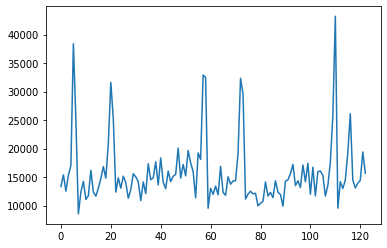

In [11]:
plt.plot(weekly_serie)

In [12]:
# sizes of train, validation and test
num_train_samples = int(0.6 * len(weekly_serie))
num_val_samples = int(0.2 * len(weekly_serie))
num_test_samples = len(weekly_serie) - num_train_samples - num_val_samples


# create dataset for training, validation, and testing
# with the goal of predict the third week after the current:
# Ex: sequence_length=3, leap=3
#  raw_data = [0, 1, 2, 3, 4, 6] => input = [0, 1, 2], target = 6

sampling_rate = 1
sequence_length = 12
leap = 3
delay = sampling_rate * (sequence_length + leap - 1)

batch_size = 2

train_dataset = keras.utils.timeseries_dataset_from_array(
    weekly_serie[:-leap],
    targets=weekly_serie[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples - leap)

val_dataset = keras.utils.timeseries_dataset_from_array(
    weekly_serie[:-leap],
    targets=weekly_serie[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples - delay,
    end_index=num_train_samples + num_val_samples - leap)

test_dataset = keras.utils.timeseries_dataset_from_array(
    weekly_serie[:-leap],
    targets=weekly_serie[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples - delay)

2022-05-17 00:54:49.750243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 00:54:49.750286: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 00:54:49.750301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (66cbabd80852): /proc/driver/nvidia/version does not exist
2022-05-17 00:54:49.750530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
for x, y in train_dataset.take(1):
    print("Intput\n", x)
    print("Output\n", y)

Intput
 tf.Tensor(
[[12099. 17342. 14544. 14870. 17676. 13659. 18363. 14110. 12978. 16061.
  14225. 15163.]
 [14870. 17676. 13659. 18363. 14110. 12978. 16061. 14225. 15163. 15461.
  20100. 14825.]], shape=(2, 12), dtype=float64)
Output
 tf.Tensor([14825. 19663.], shape=(2,), dtype=float64)


## 4. Modelos Predictivos

In [14]:
def plot_loss(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

### 4.1 Baseline

Cuando se desarrolla un solución análitica desde cero es bueno partir creando una solución base, de esta manera tenemos un punto de comparación de que tan bien o mal lo estan haciendo los modelos. La solución base propuesta consiste en una heurística que utiliza la demanda de la semana actual para predecir la demanda en dos semanas. Matemáticamente:

$$\hat{y}_{t+3} = y_{t}$$

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0.
    for samples, targets in dataset:
        preds = tf.convert_to_tensor([value[-1] for value in samples])
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4335.79
Test MAE: 7006.79


### 4.2 Linear Model

El modelo linea predice el siguiente la demanda semanal como $\hat{y}_{t+3} = b + w_{1}y_{t} + w_{2}y_{t-1} + ... + w_{p-1}y_{t-p+1}$, donde $p$ es el orden. En este caso se fijo $p=12$, lo cual corresponde a 12 semanas. Se ajustan los parámetros mediante mini-batch gradient descent. Se utiliza el conjunto de validación para escoger el modelo minimiza la función de pérdida "Mean Square Error". Vale la pena mencionar que el hiperparámetro $p$ se puede calibrar en el conjunto de validación, sin embargo, se decidió no hacerlo debido a que trata de un MVP.

Epoch 1/100
30/30 [==============================] - 0s 4ms/step - loss: 91026224.0000 - mae: 7880.2559 - val_loss: 54567748.0000 - val_mae: 6182.3770
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 85307392.0000 - mae: 7531.6001 - val_loss: 49869156.0000 - val_mae: 5886.7310
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 79931064.0000 - mae: 7243.2393 - val_loss: 47650752.0000 - val_mae: 5667.3091
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 77809936.0000 - mae: 7015.8608 - val_loss: 47806828.0000 - val_mae: 5587.8145
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 73873272.0000 - mae: 6786.7139 - val_loss: 45194404.0000 - val_mae: 5348.4961
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 69894792.0000 - mae: 6528.0850 - val_loss: 44016868.0000 - val_mae: 5184.3228
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 68281248.0000 - mae: 

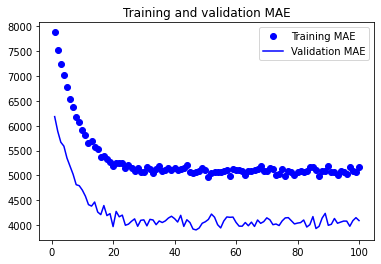

In [17]:
inputs = keras.Input(shape=(sequence_length, 1))
outputs = layers.Dense(1)(inputs)
ar_model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("ar_model.keras",
                                    save_best_only=True)
]
ar_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = ar_model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)

ar_model = keras.models.load_model("ar_model.keras")
print(f"Test MAE: {ar_model.evaluate(test_dataset)[1]:.2f}")
plot_loss(history)

### 4.3 LSTM

LSTM es una red neural recurrente, en donde la predicción viene dada por $\hat{y}_{t+3} = f(y_{t}, y_{t-1}, ..., y_{t-p})$, donde $p$ es el largo de la secuencia el cual puede no ser fijo. Se utiliza el mismo largo de secuencia que en el modelo linal, es decir, $p=12$.

Epoch 1/100
30/30 [==============================] - 3s 27ms/step - loss: 287642464.0000 - mae: 16159.1328 - val_loss: 287609632.0000 - val_mae: 16158.1260
Epoch 2/100
30/30 [==============================] - 1s 16ms/step - loss: 287498688.0000 - mae: 16154.9385 - val_loss: 287396416.0000 - val_mae: 16151.5303
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 287290208.0000 - mae: 16147.8252 - val_loss: 286998336.0000 - val_mae: 16139.1963
Epoch 4/100
30/30 [==============================] - 1s 16ms/step - loss: 286507104.0000 - mae: 16123.4141 - val_loss: 286162592.0000 - val_mae: 16113.2842
Epoch 5/100
30/30 [==============================] - 1s 16ms/step - loss: 285735808.0000 - mae: 16102.6201 - val_loss: 284938688.0000 - val_mae: 16075.2607
Epoch 6/100
30/30 [==============================] - 1s 18ms/step - loss: 284469408.0000 - mae: 16058.4121 - val_loss: 283131392.0000 - val_mae: 16018.9463
Epoch 7/100
30/30 [==============================] - 1s 20ms/ste

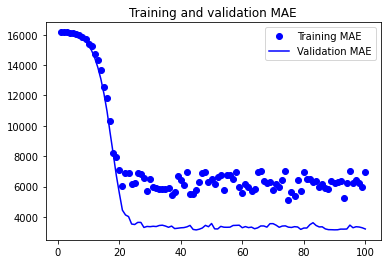

In [18]:
inputs = tf.keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
lstm_model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_model.keras",
                                    save_best_only=True)
]
lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = lstm_model.fit(train_dataset,
                         epochs=100,
                         validation_data=train_dataset,
                         callbacks=callbacks)
lstm_model = keras.models.load_model("lstm_model.keras")
print(f"Test MAE: {lstm_model.evaluate(train_dataset)[1]:.2f}")
plot_loss(history)

In [691]:
df[df.VENTAS > 9000]

,FECHA,VENTAS
43,2017-09-13,9454.000000
46,2017-09-16,9775.000000
140,2017-12-23,9430.000000
146,2017-12-30,9694.000000
403,2018-09-15,10878.000000
506,2018-12-30,9515.000000
762,2019-09-14,9362.665071
764,2019-09-16,9632.299988
765,2019-09-17,9786.519964


## 5. Conclusión

Se escoge el modelo con mejor capacidad de generalización, es decir, el que posee mejor desempeño en el conjunto de test, el cual viene siendo LSTM con un MAE de 3141.33, al cual le sigue Linear Model con 5781.69 y por último el Baseline con 7006.79. En caso que la interpretabilidad sea importante se sugiere escoger el modelo lineal, ya que los parámetros estimados dan una idea de la importancia de los lags.

El modelo escogido se desempeña de manera aceptable teniendo en cuenta que la demanda promedio es 15730, por lo que en promedio nos equivocaremos en 3141 unidades. Sin embargo, este modelo se podría mejorar ingestando otro tipo de información, como fechas de partidos de futboll, ofertas y otro tipo de información que el negocio considere relevante. Adicionalmente, se identifica que en dos momentos del año se obtiene un pick considerable de demanda, estas fechas considen con la semana/s 18 de Septiembre y Navidad-Año Nuevo. Se sugiere tratar esas semanas anómalas y escasas en datos con una heurística (ej: promedio de años anteriores).

Para manejar un aumento importante en la cantidad de este tipo de problemas es necesario desarrollar soluciones fáciles de automatizar. Una de las razones por la que Machine Learning ha sido tan exitoso (a parte de la gran disponibilidad de datos y cómputo) es que permite escalar soluciones analíticas sin la necesidad de programar la solución de forma explícita, característica de la cual carece el paradigma tradicional de AI, en donde problemas analíticos complejos se vuelven en un monton de reglas (if/else) que rápidamente escalan en complejidad y se vuelven difíciles de gestionar. En línea con lo mencionado anteriormente, para escalar la solución a múltiples productos y países se debe desarrollar un engranaje de MLOps. Por ejemplo, un equipo desarrolla un modelo genérico, con cierta flexibilidad a nivel de input(ej: más/menos columnas, features), de esta manera el equipo que desarrolla el modelo puede gatillar con un pull request múltiples reentrenamientos en paralelo del mismo modelo en múltiples conjuntos de datos, reemplazando los modelos antiguos, luego estos modelos son llamados períodicamente por un aplicativo de orquestación (ej: Airflow) para escribir las predicciones en un base de datos.